# Neural Network using Pytorch library

In [58]:
import os
import pandas as pd
import torch
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from torchmetrics.functional import mean_absolute_percentage_error

import numpy as np


## Check if hardware accelerators such as GPU or MPS are available, if not CPU

In [59]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [60]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('clean.csv')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']).values, df['price'].values, test_size=0.2, random_state=42)


In [62]:
from torch.utils.data import Dataset, DataLoader
import torch

class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Ensure target is 2D for regression

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets and data loaders
train_dataset = FlightDataset(X_train, y_train)
test_dataset = FlightDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
import torch.nn.functional as F
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Single output for regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [64]:
input_size = X_train.shape[1]  # Number of features

model = PricePredictor(input_size).to(device)
print(model)

criterion = nn.MSELoss()  # Regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

PricePredictor(
  (fc1): Linear(in_features=27, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [65]:
epochs = 50

for epoch in range(epochs):
    model.train()  # Training model
    total_loss = 0

    for inputs, targets in train_loader:
        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/50], Loss: 2793154465.7920
Epoch [2/50], Loss: 1532201087.2320
Epoch [3/50], Loss: 504275804.5440
Epoch [4/50], Loss: 473341178.3680
Epoch [5/50], Loss: 469433056.5120
Epoch [6/50], Loss: 465638037.8880
Epoch [7/50], Loss: 461483116.8000
Epoch [8/50], Loss: 457064272.6400
Epoch [9/50], Loss: 452076121.7280
Epoch [10/50], Loss: 447526568.1920
Epoch [11/50], Loss: 442076689.7920
Epoch [12/50], Loss: 437159771.7760
Epoch [13/50], Loss: 431424970.4960
Epoch [14/50], Loss: 425216834.0480
Epoch [15/50], Loss: 418248731.1360
Epoch [16/50], Loss: 411366601.3440
Epoch [17/50], Loss: 403662548.3520
Epoch [18/50], Loss: 394441229.1840
Epoch [19/50], Loss: 385129102.5920
Epoch [20/50], Loss: 374349304.5760
Epoch [21/50], Loss: 362100104.9600
Epoch [22/50], Loss: 348437086.9760
Epoch [23/50], Loss: 333333761.5360
Epoch [24/50], Loss: 316658875.0080
Epoch [25/50], Loss: 299164294.5280
Epoch [26/50], Loss: 281213605.1200
Epoch [27/50], Loss: 263719670.9760
Epoch [28/50], Loss: 248740381.8880

In [66]:
model.eval()  # Evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in test_loader:
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Loss: 174704367.5000


In [67]:
predicted_prices = []
y_test_list = []

for x, y in test_loader:
    predicted_price = model(x)
    predicted_prices += predicted_price.squeeze().tolist()
    y_test_list += y.squeeze().tolist()

    for y_test, pred in zip(y, predicted_price):
        print(f"Real: {y_test.item():.2f} \t Predicted: {pred.item():.2f}")

Real: 45185.00 	 Predicted: 63894.71
Real: 69179.00 	 Predicted: 48002.09
Real: 53937.00 	 Predicted: 56770.96
Real: 55377.00 	 Predicted: 63409.85
Real: 56702.00 	 Predicted: 33515.34
Real: 55502.00 	 Predicted: 62183.20
Real: 55997.00 	 Predicted: 39785.89
Real: 54684.00 	 Predicted: 38658.78
Real: 60978.00 	 Predicted: 59638.96
Real: 53937.00 	 Predicted: 57372.93
Real: 54841.00 	 Predicted: 56752.25
Real: 57017.00 	 Predicted: 48759.44
Real: 60978.00 	 Predicted: 40090.85
Real: 48718.00 	 Predicted: 65426.79
Real: 57017.00 	 Predicted: 54519.37
Real: 49553.00 	 Predicted: 58881.86
Real: 27792.00 	 Predicted: 52276.84
Real: 77329.00 	 Predicted: 51567.25
Real: 62448.00 	 Predicted: 44159.34
Real: 54777.00 	 Predicted: 59840.42
Real: 51707.00 	 Predicted: 48454.15
Real: 73369.00 	 Predicted: 55422.17
Real: 47586.00 	 Predicted: 65474.18
Real: 66077.00 	 Predicted: 42347.66
Real: 34460.00 	 Predicted: 35279.46
Real: 80544.00 	 Predicted: 57973.38
Real: 54608.00 	 Predicted: 53304.45
R

In [68]:
print("Longitud de y_test_list:", len(y_test_list))
print("Longitud de predicted_prices:", len(predicted_prices))


Longitud de y_test_list: 1000
Longitud de predicted_prices: 1000


In [69]:
real_tensor = torch.tensor(y_test_list)
predicted_tensor = torch.tensor(predicted_prices)

In [70]:
# Calculate MSE, MAE and MAPE
print(
  'mean_squared_error : ', mean_squared_error(y_test_list, predicted_prices))
print(
  ' mean_absolute_error : ', mean_absolute_error(y_test_list, predicted_prices))
print(
  'mean_absolute_percentage_error : ', mean_absolute_percentage_error(real_tensor, predicted_tensor))



mean_squared_error :  173522562.7991114
 mean_absolute_error :  10617.980119140626
mean_absolute_percentage_error :  tensor(0.2163)


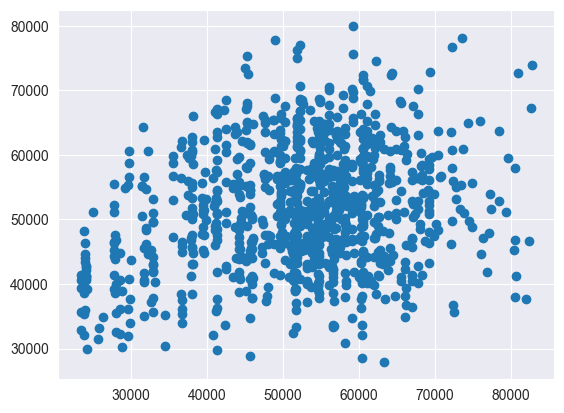

In [71]:
import matplotlib.pyplot as plt

plt.scatter(y_test_list, predicted_prices)


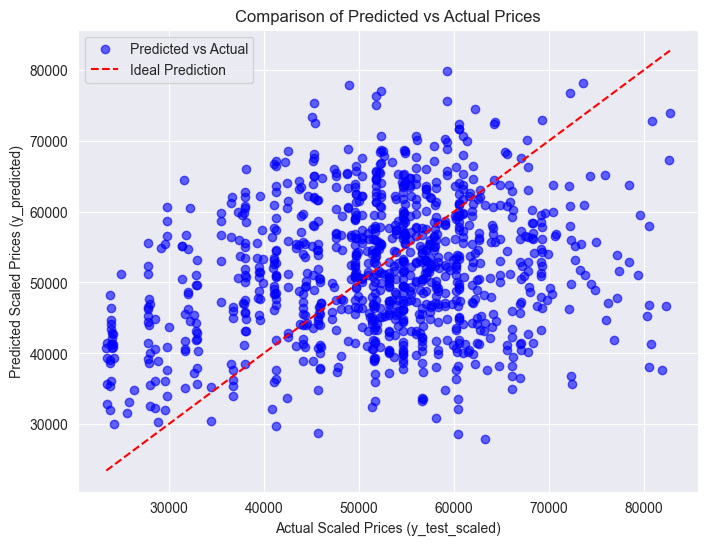

In [72]:
# Assuming y_predicted and y_test_scaled are numpy arrays or lists
plt.figure(figsize=(8, 6))
plt.scatter(y_test_list, predicted_prices, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test_list), max(y_test_list)], [min(y_test_list), max(y_test_list)], 'r--', label='Ideal Prediction')
plt.xlabel('Actual Scaled Prices (y_test_scaled)')
plt.ylabel('Predicted Scaled Prices (y_predicted)')
plt.title('Comparison of Predicted vs Actual Prices')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
np.random.random(50)

array([0.86903098, 0.6860551 , 0.91923152, 0.63356262, 0.80868759,
       0.32333089, 0.48666713, 0.72914426, 0.67349046, 0.76183492,
       0.0821429 , 0.25502771, 0.74661084, 0.18890766, 0.20931029,
       0.63800847, 0.95586104, 0.93293779, 0.85851278, 0.15710352,
       0.86178971, 0.59884847, 0.4077411 , 0.00738004, 0.96980513,
       0.58139321, 0.46645108, 0.14721475, 0.4757136 , 0.06265881,
       0.69590732, 0.50893929, 0.42581629, 0.99042578, 0.16595762,
       0.48146135, 0.11348906, 0.42523801, 0.11632149, 0.47219783,
       0.60036621, 0.98757527, 0.26031832, 0.63562673, 0.14799083,
       0.25777855, 0.50985698, 0.73212058, 0.68938347, 0.55244303])